<br><br>

## Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('/content/drive/MyDrive/CIENTISTA DE DADOS/MENTORAMA - AULAS/MODULO 15/u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('/content/drive/MyDrive/CIENTISTA DE DADOS/MENTORAMA - AULAS/MODULO 15/u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [4]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [ ]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [ ]:
df = getDF()
df

<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [ ]:
ratings = df.fillna(0).values
ratings

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [9]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [ ]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [ ]:
#matriz de interação - original;

ratings

In [ ]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

In [ ]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [ ]:
train, val = train_test_split(train, qtd = 2)

In [ ]:
train

In [ ]:
val

In [ ]:
test

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [ ]:
train + val + test

In [ ]:
(train + val + test) == ratings

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [ ]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [ ]:
fat.fit()

In [ ]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [ ]:
pd.DataFrame(val, columns = df.columns, index = df.index)

<br>

## Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,Filme_11,Filme_12,Filme_13,Filme_14,Filme_15,Filme_16,Filme_17,Filme_18,Filme_19,Filme_20,Filme_21,Filme_22,Filme_23,Filme_24,Filme_25,Filme_26,Filme_27,Filme_28,Filme_29,Filme_30,Filme_31,Filme_32,Filme_33,Filme_34,Filme_35,Filme_36,Filme_37,Filme_38,Filme_39,Filme_40,Filme_41,Filme_42,Filme_43,Filme_44,Filme_45,Filme_46,Filme_47,Filme_48,Filme_49,Filme_50,Filme_51,Filme_52,Filme_53,Filme_54,Filme_55,Filme_56,Filme_57,Filme_58,Filme_59,Filme_60,Filme_61,Filme_62,Filme_63,Filme_64,Filme_65,Filme_66,Filme_67,Filme_68,Filme_69,Filme_70,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,2.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,3.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,3.0,2.0,5.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,NaN,4.0,2.0,5.0,3.0,NaN,NaN,NaN,4.0,NaN,3.0,3.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,4.0,5.0,3.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,2.0,4.0,5.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,NaN,4.0,5.0,1.0,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,1.0,NaN,NaN,5.0,NaN,3.0,NaN,NaN,NaN,1.0,2.0,5.0,NaN,NaN,1.0,NaN,4.0,2.0,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN,5.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Matrix recebe os valores do dataframe R substituindo os valores null por zeros
matrix = R.fillna(0).values

In [10]:
#Divisão da matrix em treino e teste, removendo dois valores de cada user da matrix e passando para teste
treino, teste = train_test_split(matrix, qtd = 2)

In [11]:
#Divisão da matriz treino em treino e validação, removendo dois valores de cada user de treino e passando para validação
treino, validacao = train_test_split(treino,qtd = 2)

In [17]:
#GRID-SEARCH

s = 50
k_seq =[5, 10, 15, 20]
alfa = [0.001, 0.002, 0.003, 0.004, 0.01]
beta = [0.01, 0.02, 0.03, 0.04]

for k in k_seq:
    for a in alfa:
      for b in beta:
        
        ftt = MatrixFactorization(dataframe = pd.DataFrame(treino, 
                                  columns = R.columns, 
                                  index = R.index), 
                                  K = k, 
                                  steps = s, 
                                  alpha = a, 
                                  beta = b)
        ftt.fit()
        predito = ftt.predict()

        mse_total = 0
       
        #Verifica cada informação da matriz matrix que não contem zero e avalia pela matriz predito 
        for l in range(len(matrix)):
          for c in range(len(matrix[l])):
            if matrix[l][c] > 0:
              eij = matrix[l][c] - predito[l][c]
              mse_total += (eij)**2

        print('K: {}, alfa: {}, beta: {}'.format(k,a,b))
        print('MSE Treino: ', np.min(ftt.lista_erro_step))
        print('MSE Treino/Validação:', mse_total)
        print("====" * 10)

Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.001, beta: 0.01
MSE Treino:  5439.383695932327
MSE Treino/Validação: 6699.140993069596
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.001, beta: 0.02
MSE Treino:  5369.138878550118
MSE Treino/Validação: 6624.308752167046
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.001, beta: 0.03
MSE Treino:  5423.2366289870015
MSE Treino/Validação: 6669.8576329126045
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.001, beta: 0.04
MSE Treino:  5466.145636129763
MSE Treino/Validação: 6729.720047891622
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.002, beta: 0.01
MSE Treino:  4870.213705409718
MSE Treino/Validação: 6102.165676695098
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.002, beta: 0.02
MSE Treino:  4858.826509414376
MSE Treino/Validação: 6051.76623126175
Fatoração concluída. Tempo aproximado: 1 minuto(s).
K: 5, alfa: 0.002, beta: 0.03

## Melhores Parametros obtidos:

Buscando o Menor MSE, tivemos:

*   K: 20
*   alfa: 0.01 
*   beta: 0.03




### Aplicando o Modelo que melhor performou os dados, e aplicando steps = 1000 para obter um resultado melhor.

In [39]:
#Aplicando o Melhor modelo
fat_final = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = 20, steps = 1000 , alpha = 0.01, beta = 0.03)

In [40]:
fat_final.fit()

Fatoração concluída. Tempo aproximado: 18 minuto(s).


In [41]:
print('MSE Treino',fat_final.lista_erro_step[-1])

MSE Treino 301.1966034876435


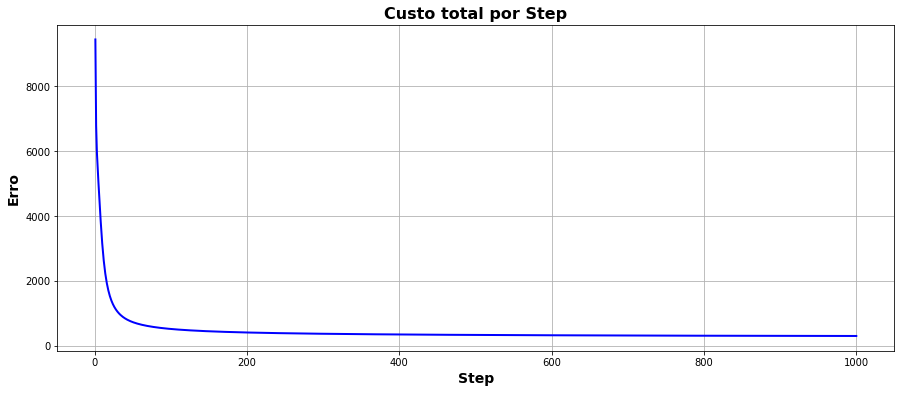

In [42]:
fat_final.print_MSE_steps()

In [43]:
#Dataset do Valores Predito pelos parametros escolhidos
pd.DataFrame(fat_final.predict(), columns = R.columns, index = R.index).round(2).head()

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,Filme_11,Filme_12,Filme_13,Filme_14,Filme_15,Filme_16,Filme_17,Filme_18,Filme_19,Filme_20,Filme_21,Filme_22,Filme_23,Filme_24,Filme_25,Filme_26,Filme_27,Filme_28,Filme_29,Filme_30,Filme_31,Filme_32,Filme_33,Filme_34,Filme_35,Filme_36,Filme_37,Filme_38,Filme_39,Filme_40,Filme_41,Filme_42,Filme_43,Filme_44,Filme_45,Filme_46,Filme_47,Filme_48,Filme_49,Filme_50,Filme_51,Filme_52,Filme_53,Filme_54,Filme_55,Filme_56,Filme_57,Filme_58,Filme_59,Filme_60,Filme_61,Filme_62,Filme_63,Filme_64,Filme_65,Filme_66,Filme_67,Filme_68,Filme_69,Filme_70,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,4.39,3.25,3.88,2.36,3.17,4.83,3.54,1.72,5.20,3.30,2.32,2.88,4.44,4.21,4.52,4.71,2.92,3.86,4.83,3.92,1.35,4.98,4.03,2.66,3.86,3.20,2.15,4.29,1.46,3.14,3.08,4.65,3.69,0.69,0.98,2.01,2.01,2.44,3.67,3.01,2.25,4.77,3.75,4.60,4.80,3.68,3.65,5.05,2.68,5.76,3.78,4.29,2.99,3.41,4.76,4.39,4.99,4.15,5.26,4.85,4.14,3.29,2.15,4.67,3.49,3.61,2.98,4.24,2.65,3.65,3.33,3.99,3.13,1.07,4.02,3.98,3.95,0.94,3.44,3.84
User_1,3.81,2.80,3.77,2.61,3.82,4.35,4.91,3.19,6.06,2.03,3.01,3.30,1.42,3.38,4.02,3.38,3.84,2.53,3.14,2.32,-0.22,3.30,2.65,3.99,2.94,3.96,1.53,2.18,0.53,2.43,1.05,4.13,2.87,2.53,0.70,1.66,1.93,1.48,1.74,3.98,4.46,5.05,2.35,4.07,4.98,3.65,2.97,5.33,1.31,3.99,1.68,3.52,1.76,2.32,4.14,4.16,3.63,4.54,3.39,4.19,3.29,2.33,1.15,3.45,2.89,1.22,2.77,1.25,1.19,3.94,1.48,1.74,2.76,1.99,2.18,4.90,1.64,2.85,2.81,2.95
User_2,3.83,1.41,0.69,3.25,2.38,2.04,2.04,4.02,4.07,3.66,3.12,3.97,2.06,4.82,3.03,2.37,4.04,1.86,3.96,2.64,1.19,2.99,4.06,2.84,2.71,3.82,0.83,2.17,1.36,3.21,2.67,4.73,4.15,1.72,1.17,2.15,1.93,0.81,2.80,3.15,2.55,4.37,2.19,3.42,5.03,3.35,2.92,5.35,3.44,4.04,2.42,4.73,2.98,1.35,2.48,4.02,3.13,2.43,4.92,3.59,4.08,2.50,1.50,3.84,3.86,2.23,3.79,3.57,3.00,3.17,3.99,3.14,1.28,2.86,2.62,3.00,2.13,2.37,3.05,4.00
User_3,4.51,5.53,5.22,4.87,4.05,3.95,4.75,4.97,5.06,3.97,3.18,4.95,6.09,1.67,1.15,3.24,1.88,2.72,2.65,6.38,3.29,4.75,3.05,3.17,3.11,2.83,3.77,5.90,2.77,3.23,4.22,1.92,4.10,1.61,1.16,1.86,1.06,3.28,3.97,2.39,3.89,5.22,3.62,2.34,5.02,2.53,4.97,2.15,3.23,4.92,2.12,4.14,5.02,2.79,5.65,4.84,2.44,3.06,4.91,4.77,2.03,2.99,4.68,4.63,4.25,2.91,2.23,4.04,4.74,1.50,4.99,4.70,3.22,2.06,2.48,4.78,4.86,2.88,4.32,3.95
User_4,4.05,1.93,2.53,3.92,3.73,3.71,3.96,5.25,3.97,4.85,4.73,5.06,3.00,5.37,4.09,3.96,4.77,2.42,3.00,2.97,2.77,4.87,4.89,3.43,4.24,3.79,2.02,3.55,3.35,3.94,3.49,3.98,3.46,1.85,1.45,1.85,2.69,2.94,2.68,3.86,1.82,3.84,1.67,4.73,4.16,3.62,3.25,4.01,2.66,5.09,3.15,3.64,4.55,3.09,3.12,4.93,3.93,3.94,3.89,3.17,2.98,1.92,2.01,4.00,3.58,4.17,3.26,3.55,3.77,4.04,3.63,2.58,4.16,3.62,3.12,3.65,3.10,3.35,4.32,2.33


In [44]:
#Matriz real dos valores, onde 0 representa valores faltantes
pd.DataFrame(matrix, columns = R.columns, index = R.index).head()

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,Filme_11,Filme_12,Filme_13,Filme_14,Filme_15,Filme_16,Filme_17,Filme_18,Filme_19,Filme_20,Filme_21,Filme_22,Filme_23,Filme_24,Filme_25,Filme_26,Filme_27,Filme_28,Filme_29,Filme_30,Filme_31,Filme_32,Filme_33,Filme_34,Filme_35,Filme_36,Filme_37,Filme_38,Filme_39,Filme_40,Filme_41,Filme_42,Filme_43,Filme_44,Filme_45,Filme_46,Filme_47,Filme_48,Filme_49,Filme_50,Filme_51,Filme_52,Filme_53,Filme_54,Filme_55,Filme_56,Filme_57,Filme_58,Filme_59,Filme_60,Filme_61,Filme_62,Filme_63,Filme_64,Filme_65,Filme_66,Filme_67,Filme_68,Filme_69,Filme_70,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,2.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,3.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,3.0,2.0,5.0,4.0,4.0,3.0,4.0,3.0,3.0,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,4.0,2.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,3.0,0.0,4.0,5.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,2.0,4.0,5.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,4.0,5.0,1.0,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
User_4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,4.0,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Calcula por Linha x Coluna o valor dos dados treino/validação/teste pelo valor Predito
#Verificando o erro atravez da subtração dos dados e realizando a somatoria

def mse_treino_val_teste(df, predito):
  mse_total = 0
  for l in range(len(df)):
    for c in range(len(df[l])):
      if df[l][c] > 0:
        eij = df[l][c] - predito[l][c]
        mse_total += (eij)**2
  print(mse_total)

In [46]:
#MSE no Dados de Treino
pred_final = fat_final.predict()
mse_treino_val_teste(treino, pred_final)

259.5474737355502


In [47]:
#MSE no Dados de Validação
pred_final = fat_final.predict()
mse_treino_val_teste(validacao, pred_final)

1164.4644872103204


In [48]:
#MSE nos Dados de Teste
pred_final = fat_final.predict()
mse_treino_val_teste(teste, pred_final)

1209.082773097962
